# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle as pkl
from scipy.stats import norm
from scipy.stats import ttest_ind, ttest_rel, ranksums, wilcoxon

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils
from backend import metrics_utils

# Load Basin Attributes for Latitude & Longitude

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [5]:
attributes = loading_utils.load_attributes_file(gauges=gauges)

# Load Return Period Metrics

In [6]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [7]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [8]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Scores Map

There are 3673 gauges with f1 scores for return period 2.0.


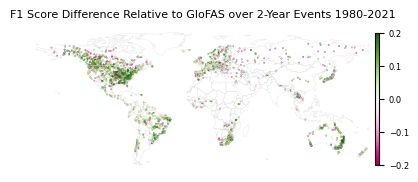

In [9]:
lead_time = 0
return_period = 2.00

f1s = pd.concat(
    [
        f1s_by_lead_time['glofas_1980'][
            metrics_utils.GLOFAS_VARIABLE][
            lead_time][return_period].rename(metrics_utils.GLOFAS_VARIABLE),
        f1s_by_lead_time['google_1980'][
            'kfold_splits'][lead_time][
            return_period].rename(metrics_utils.GOOGLE_VARIABLE)
    ],
    axis=1
).dropna()

metric = 'F1 Score Difference'
f1s[metric] = f1s[metrics_utils.GOOGLE_VARIABLE] - f1s[metrics_utils.GLOFAS_VARIABLE]

print(f'There are {f1s.shape[0]} gauges with f1 scores for return period {return_period}.')

title = f'{metric} Relative to GloFAS over {int(return_period)}-Year Events 1980-2021'
_ = evaluation_utils.spatial_plot(
    latlon=attributes,
    metric=metric,
    title=title,
    metric_data=f1s[metric],
    vmin=-0.2, 
    vmax=0.2,
    cmap='PiYG',
    ms=0.05
)

# Save figure
evaluation_utils.save_figure(data_paths.GLOBAL_F1_SCORES_MAP_FILENAME)

# Fraction of Improved Basins

In [10]:
metric = 'F1 Score Difference'

for return_period in evaluation_utils.RETURN_PERIODS:

    print(f'--- Return Period = {return_period} -------------------------------------------')

    f1s = pd.concat(
      [
          f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][lead_time][return_period].rename('glofas'),
          f1s_by_lead_time['google_1980']['kfold_splits'][lead_time][return_period].rename('google')
      ],
      axis=1
    ).dropna()
    f1s[metric] = f1s['google'] - f1s['glofas']

    print('Total number of gauges: ', f1s.shape[0])
    print('Gauges with nonnegative differences: ', f1s[f1s[metric] >= 0].shape[0])
    print('Fraction with nonnegative differences: ', f1s[f1s[metric] >= 0].shape[0] / f1s.shape[0])
    print('Fraction with positive differences: ', f1s[f1s[metric] > 0].shape[0] / f1s.shape[0])

    print('\n')
    stats = wilcoxon(f1s['google'],f1s['glofas'])
    cohen_d = evaluation_utils.cohen_d(f1s['google'].values, f1s['glofas'].values)
    zstatistic = norm.isf(stats.pvalue / 2)
    effect_size = zstatistic / f1s.shape[0]**(1/2)
    print(stats, effect_size, cohen_d)

    print('-------------------------------------------------------------------- \n\n')


--- Return Period = 1.01 -------------------------------------------
Total number of gauges:  3638
Gauges with nonnegative differences:  2373
Fraction with nonnegative differences:  0.6522814733369984
Fraction with positive differences:  0.6371632765255635


WilcoxonResult(statistic=1986506.0, pvalue=6.150123346315951e-87) 0.32766542484191846 0.2212190806598745
-------------------------------------------------------------------- 


--- Return Period = 2 -------------------------------------------
Total number of gauges:  3673
Gauges with nonnegative differences:  2677
Fraction with nonnegative differences:  0.7288320174244487
Fraction with positive differences:  0.697250204192758


WilcoxonResult(statistic=1405997.0, pvalue=3.8224505158043516e-181) 0.4735550125097372 0.4137948401555436
-------------------------------------------------------------------- 


--- Return Period = 5 -------------------------------------------
Total number of gauges:  3360
Gauges with nonnegative differences